## Emoji Polysemy Clustering: Prayer Hands

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from transformers import AutoTokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA, LatentDirichletAllocation
from umap import UMAP
import emoji
from tqdm import tqdm
from collections import defaultdict
from wordcloud import WordCloud, STOPWORDS
import warnings


In [3]:
warnings.filterwarnings("ignore")
plt.style.use("ggplot")

In [4]:
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True, use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Load in dataframe of emoji vectors

In [5]:
df = pd.read_pickle("emoji_vectors_data.pkl").set_index("tweet_id")
df.head()

,embedding,emoji_id
tweet_id,,
748304287315468288,"[-0.47280642, 0.11537896, 0.27408963, 0.137825...",871
593564841647992832,"[-0.20254304, -0.1832999, -0.08655356, 0.12977...",871
1189693284391833600,"[-0.29617956, -0.16728494, 0.20603363, 0.20679...",871
660244596664893440,"[-0.1807276, -0.016389936, 0.11193222, 0.14420...",871
538844422410993664,"[0.36076596, -0.046867955, 0.16463731, 0.15527...",871


Load in twitter metadata

In [6]:
tweets = pd.read_csv("tweets_data.csv").dropna(subset=["tweet_id"]).set_index("tweet_id")
tweets.head()

,author_id,created_at,geo,like_count,quote_count,reply_count,retweet_count,text
tweet_id,,,,,,,,
826217383039729664,431948312,2017-01-30 23:55:49+00:00,,0.0,0.0,0.0,0.0,We have the power👊💥😂💚 https://t.co/8en3JNwkny
869704038048202752,418718492,2017-05-30 23:56:15+00:00,,0.0,0.0,0.0,0.0,Sleep would be nice but Maiyahs cosies are bet...
792878143887605760,340099697,2016-10-30 23:57:35+00:00,{'place_id': '31fd9d42c71e7afa'},1.0,0.0,0.0,0.0,Lynn mad af cause Eric ate her chocolate chip ...
1322327339200630784,1249825087525728257,2020-10-30 23:59:39+00:00,,0.0,0.0,0.0,0.0,@KaileGedye text me cus I haven’t 🤣
979869505622069248,205097885,2018-03-30 23:54:29+00:00,,0.0,0.0,1.0,0.0,@juanlabia @Skelebird Yea but i feel like you ...


In [7]:
print(f"There are {df.emoji_id.nunique()} emojis to choose from")

There are 47 emojis to choose from


The emoji frequencies vary greatly.

In [8]:
emoji_freq = df.emoji_id.value_counts()
top_20_emoji_freq = emoji_freq.head(20).reset_index()
top_20_emoji_freq["emoji_names"] = top_20_emoji_freq["emoji_id"].map(tokenizer.convert_ids_to_tokens)
top_20_emoji_freq["emoji_symbol"] = top_20_emoji_freq["emoji_names"].map(emoji.EMOJI_UNICODE_ENGLISH)
top_20_emoji_freq.assign(frequency = top_20_emoji_freq["count"]).drop("count", axis = 1)

,emoji_id,emoji_names,emoji_symbol,frequency
0,88,:face_with_tears_of_joy:,😂,402897
1,247,:loudly_crying_face:,😭,163274
2,280,:red_heart:,❤️,114094
3,390,:smiling_face_with_heart-eyes:,😍,103253
4,933,:folded_hands:,🙏,28369
5,1658,:sparkles:,✨,27541
6,1422,:rolling_on_the_floor_laughing:,🤣,21795
7,491,:weary_face:,😩,15105
8,6239,:pleading_face:,🥺,15096
9,722,:face_blowing_a_kiss:,😘,12182


### Prayer Hands

The purpose of this notebooks is to demonstrate my methodology on a chosen emoji: the prayer hands emoji

Create dataframe of prayer hands emoji embeddings.

In [9]:
prayer_hands_id = 933
prayer_hands_df = df.query("emoji_id == {}".format(prayer_hands_id)).drop("emoji_id", axis = 1)
prayer_hands_df.head()

,embedding
tweet_id,
649010168466796544,"[0.17880017, 0.05944991, 0.029669717, 0.362047..."
649010168466796544,"[0.31431267, 0.11376719, -0.017697126, 0.36743..."
649010168466796544,"[0.27834195, 0.033847056, 0.08875726, 0.325185..."
1233542243899731968,"[-0.5153002, -0.07138766, 0.07983874, -0.02516..."
1454598713612046336,"[-0.49861014, 0.15797623, 0.02909191, 0.323536..."


In [10]:
print(f"There are {prayer_hands_df.shape[0]} instances of the prayer hands emoji")

There are 28369 instances of the prayer hands emoji


In [11]:
print(f"The prayer hands emoji has appeared in a total of {prayer_hands_df.index.nunique()} unique tweets")

The prayer hands emoji has appeared in a total of 21019 unique tweets


A tiny sample of the tweets in this dataframe frequently use the prayer hands emojis

In [12]:
prayer_hands_df.index.value_counts()

tweet_id
615670335338233856     43
1046187630948429824    35
1079527433794137984    29
1012848168336179200    16
494633200657121280     15
                       ..
1277753287404593152     1
1012848084865486848     1
1454598945892618240     1
1322326937109409792     1
561312901492129792      1
Name: count, Length: 21019, dtype: int64

Let's see there are any temporal trends in the prayer hands emoji in this eight year time-span.

Connect the timestamp data from tweets by joining `tweets` with `prayer_hands_df`

In [13]:
prayer_hands_df = prayer_hands_df.join(tweets)

In [14]:
tweet_rate = pd.Series(index=pd.to_datetime(prayer_hands_df.created_at)).sort_index()

Plot the monthly frequency of the prayer hands emoji appearing in tweets from 2014-2022

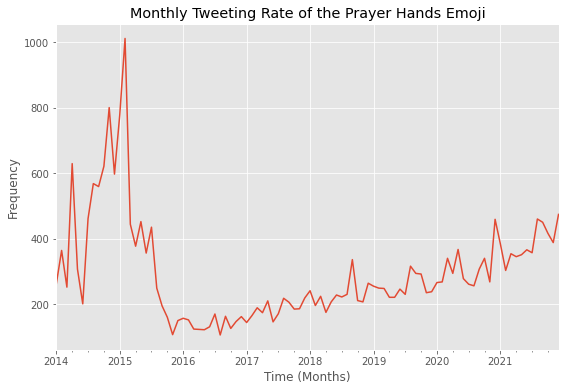

In [15]:
tweet_rate.resample("M").size().plot(figsize = (9,6))
plt.xlabel("Time (Months)")
plt.ylabel("Frequency")
plt.title("Monthly Tweeting Rate of the Prayer Hands Emoji");

There was a big spike in 2015, followed by a crash in 2016, and since then it's been on a steady uprise.

### Clustering

Now let's move onto the clustering. But first we need to prepare the embeddings data.

The embeddings are hosted in a single column and need to be expanded into a dataframe whose number of columns matches the number of embedding dimensions (768).

In [16]:
prayer_embeddings = prayer_hands_df.embedding
prayer_embeddings.head()

tweet_id
429040710663168000    [-0.453158, 0.18988, 0.036986373, 0.46807036, ...
429040711967993856    [-0.48393747, 0.075945124, 0.096503735, 0.5369...
429040712110186496    [-0.390809, 0.010703653, 0.025948249, 0.408187...
429040713247256576    [0.086006545, -0.12207636, -0.00013127923, 0.3...
429040714149007360    [-0.14164633, 0.12951931, -0.13036837, 0.21130...
Name: embedding, dtype: object

This can be done by "applying" the pandas series object to the `prayer_embeddings` series.

In [17]:
prayer_embeddings = prayer_embeddings.apply(pd.Series)
prayer_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
tweet_id,,,,,,,,,,,,,,,,,,,,,
429040710663168000,-0.453158,0.189880,0.036986,0.468070,-0.181495,0.011059,0.284415,0.291082,0.086261,-0.121586,...,0.222732,-0.108561,0.428199,-0.198714,0.072036,-0.297491,-0.034543,0.411997,-0.577884,0.306727
429040711967993856,-0.483937,0.075945,0.096504,0.536984,-0.233010,0.076478,0.263545,0.281400,0.329582,-0.229880,...,0.326331,-0.090033,0.228774,0.008569,0.123350,-0.108330,0.075768,0.319844,-0.570068,0.202169
429040712110186496,-0.390809,0.010704,0.025948,0.408187,0.068880,-0.260413,0.198698,0.223967,0.350586,-0.052347,...,0.262694,-0.241800,0.160542,0.056395,0.174129,-0.066834,0.037564,0.130479,-0.792629,0.008816
429040713247256576,0.086007,-0.122076,-0.000131,0.356246,0.136972,0.115999,0.320570,0.642362,-0.057124,0.051282,...,-0.098055,-0.203933,0.063594,-0.041547,0.013217,0.001460,0.013148,-0.006622,-0.420309,-0.095764
429040714149007360,-0.141646,0.129519,-0.130368,0.211308,0.250667,-0.305791,0.393493,0.352672,0.247108,-0.157782,...,-0.119277,-0.329917,0.223291,0.157109,-0.105006,-0.148377,-0.065675,-0.218638,-0.072710,-0.204792


#### First clustering attempt

We begin with a simple KMeans model with k set to 3.

In [18]:
km = KMeans(n_clusters=3, random_state=10)
km.fit(prayer_embeddings)

KMeans(n_clusters=3, random_state=10)

In [19]:
#Extract labels
prayer_labels_k3 = km.labels_

Evaluate model using silhouette score

In [20]:
silhouette_score(prayer_embeddings, prayer_labels_k3)

0.12505859

0.125 is not a bad score but we need to conduct some parameter tuning in order to find the best k value.

In [21]:
sil_scores = []

k_range = range(2, 21)

for k in tqdm(k_range, total=19):
    km = KMeans(n_clusters=k, random_state=10)
    km.fit(prayer_embeddings)
    labels = km.labels_
    s_score = silhouette_score(prayer_embeddings, labels)
    sil_scores.append(s_score)

100%|███████████████████████████████████████████| 19/19 [08:36<00:00, 27.18s/it]


Plot the number of k values versus their corresponding silhouette scores.

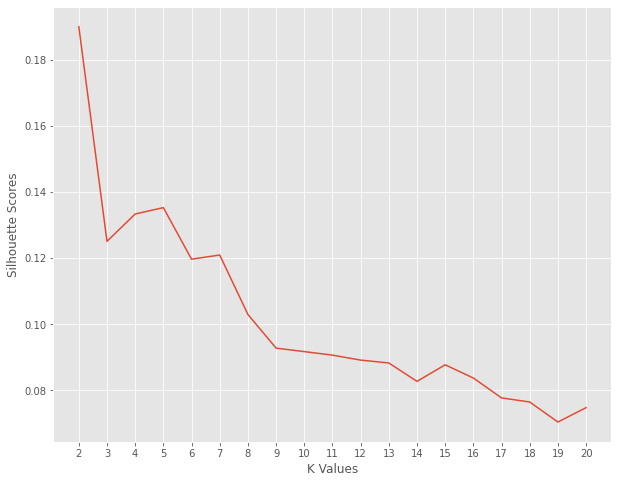

In [22]:
plt.figure(figsize = (10, 8))
plt.plot(k_range, sil_scores)
plt.xlabel("K Values")
plt.ylabel("Silhouette Scores")
plt.xticks(ticks = k_range);

2 is obviously the best k value (this is typically the case), but 5 is worth examining as becuase it's a local maximum and produces the second best score. 

Refit KMeans using 2 and 5 as k.

In [23]:
km2 = KMeans(n_clusters=2, random_state=10)
km2.fit(prayer_embeddings)
labels_2 = km2.labels_


km5 = KMeans(n_clusters=5, random_state=10)
km5.fit(prayer_embeddings)
labels_5 = km5.labels_

Transform the embeddings using TSNE for the purpose of plotting them in a 2D scatter plot, which will also use labels to color-encode the dots.

In [24]:
tsne = TSNE(random_state=10)
prayer_tsne = tsne.fit_transform(prayer_embeddings)

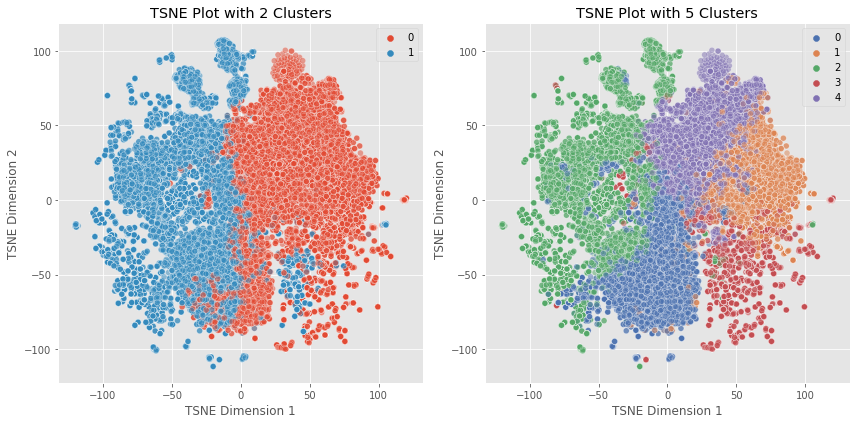

In [25]:
tsne1 = prayer_tsne[:, 0]
tsne2 = prayer_tsne[:, 1]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first scatter plot on the left subplot

sb.scatterplot(x = tsne1, y = tsne2, hue=labels_2,ax = axs[0], alpha = .5)
axs[0].set_title('TSNE Plot with 2 Clusters')

# Plot the second scatter plot on the right subplot
sb.scatterplot(x = tsne1, y = tsne2, hue=labels_5,ax = axs[1], alpha = .5, palette = "deep")
axs[1].set_title('TSNE Plot with 5 Clusters')


axs[0].set_xlabel('TSNE Dimension 1')
axs[0].set_ylabel('TSNE Dimension 2')
axs[1].set_xlabel('TSNE Dimension 1')
axs[1].set_ylabel('TSNE Dimension 2')
fig.tight_layout()
plt.savefig("prayer_hands_tsne.png", dpi = 200)
# Show the plot
plt.show()


This is a promising result, we can observe distinguishable clusters of the prayer_hands emoji's embeddings. This show that there are distinguishable clusters of the emoji's embeddings, which indicates that the prayer_hands emoji possesses a level of polysemy.

**What are the distributions of the labels for each model**

Two clusters:

In [48]:
freq = pd.value_counts(labels_2).rename("Frequency")
prop = pd.value_counts(labels_2, normalize=True).rename("Proportions")
pd.concat([freq, prop], axis = 1)

,Frequency,Proportions
0,14539,0.512496
1,13830,0.487504


For k = 2, the embeddings are close to be evenly divided between the two cluster labels.

Five clusters:

In [26]:
freq = pd.value_counts(labels_5).rename("Frequency")
prop = pd.value_counts(labels_5, normalize=True).rename("Proportions")
pd.concat([freq, prop], axis = 1)

,Frequency,Proportions
2,9468,0.333745
0,6374,0.224682
4,5429,0.191371
1,3843,0.135465
3,3255,0.114738


In [27]:
#Save the labels to the prayer_hands_df dataframe
prayer_hands_df["labels2"] = labels_2
prayer_hands_df["labels5"] = labels_5

Remember that `prayer_hands_df` has duplicate tweets because each row represent one use of the prayer hands emoji and in some tweets there are multitple instances of that emoji.

That's why I group by the `tweet_id` and apply the `value_counts` function to the cluster labels

In [28]:
labels2_df = prayer_hands_df.reset_index().groupby("tweet_id").labels2.value_counts().unstack().fillna(0)
labels2_df.head()

labels2,0,1
tweet_id,,
429040710663168000,1.0,0.0
429040711967993856,0.0,1.0
429040712110186496,1.0,0.0
429040713247256576,0.0,1.0
429040714149007360,0.0,1.0


`labels2_df` shows the frequency of each cluster appearing in a tweet.

Repeat this process for 5 labels

In [29]:
labels5_df = prayer_hands_df.reset_index().groupby("tweet_id").labels5.value_counts().unstack().fillna(0)
labels5_df.head()

labels5,0,1,2,3,4
tweet_id,,,,,
429040710663168000,0.0,0.0,0.0,0.0,1.0
429040711967993856,0.0,0.0,0.0,0.0,1.0
429040712110186496,0.0,0.0,0.0,0.0,1.0
429040713247256576,0.0,0.0,1.0,0.0,0.0
429040714149007360,1.0,0.0,0.0,0.0,0.0


### Defining topics 

Here I bring in the topic, emotions, and sentiment data. This extra data is used to help us distinguish between the emoji clusters. 

In [30]:
topics = pd.read_pickle("topic_scores_df.pkl")
emotions = pd.read_csv("tweet_emotions.csv", index_col=[0])
sentiment = pd.read_csv("sentiments.csv", index_col=[0])

In [31]:
topics.head()

,arts_&_culture,business_&_entrepreneurs,celebrity_&_pop_culture,diaries_&_daily_life,family,fashion_&_style,film_tv_&_video,fitness_&_health,food_&_dining,gaming,learning_&_educational,music,news_&_social_concern,other_hobbies,relationships,science_&_technology,sports,travel_&_adventure,youth_&_student_life
tweet_id,,,,,,,,,,,,,,,,,,,
826217383039729664,0.016335,0.002809,0.042542,0.041006,0.001388,0.000822,0.026560,0.001293,0.000906,0.001990,0.002153,0.018368,0.900727,0.037248,0.002019,0.001480,0.008375,0.001214,0.000729
869704038048202752,0.033339,0.020019,0.008277,0.928427,0.036049,0.008726,0.022503,0.005397,0.022037,0.018738,0.007847,0.010280,0.007789,0.139367,0.183162,0.013123,0.015434,0.057417,0.005741
792878143887605760,0.049794,0.024329,0.016242,0.800291,0.354433,0.007569,0.019055,0.011927,0.894959,0.018831,0.016835,0.018176,0.031969,0.050481,0.134443,0.016929,0.037986,0.043149,0.021827
1322327339200630784,0.008946,0.006743,0.073223,0.878838,0.021650,0.005687,0.008047,0.003915,0.007562,0.004917,0.005669,0.026181,0.013558,0.093159,0.199417,0.003914,0.038573,0.007115,0.008394
979869505622069248,0.040473,0.068227,0.210160,0.151031,0.012991,0.923727,0.075072,0.019732,0.007009,0.017731,0.013973,0.015932,0.028739,0.053301,0.028329,0.010131,0.036371,0.020247,0.013523


In [32]:
emotions.head()

,others,joy,sadness,anger,surprise,disgust,fear
tweet_id,,,,,,,
826217383039729664,0.120837,0.870141,0.001321,0.002533,0.002166,0.001234,0.001768
869704038048202752,0.966302,0.014712,0.004544,0.001032,0.004794,0.004922,0.003694
792878143887605760,0.955326,0.031291,0.001884,0.001713,0.005112,0.001853,0.002820
1322327339200630784,0.967165,0.015512,0.002577,0.001353,0.004344,0.003581,0.005467
979869505622069248,0.853755,0.136055,0.002361,0.001260,0.003110,0.001806,0.001653


In [33]:
sentiment.head()

,NEG,NEU,POS
tweet_id,,,
826217383039729664,0.001286,0.018530,0.980184
869704038048202752,0.002329,0.085571,0.912100
792878143887605760,0.707808,0.262017,0.030175
1322327339200630784,0.020357,0.629984,0.349659
979869505622069248,0.001401,0.022682,0.975917


### Two labels

#### Topics 


For the topic modeling portion I used an open source [topic model](https://huggingface.co/cardiffnlp/tweet-topic-21-multi) hosted on huggingface. This model is trained on twitter data and outputs topic ratings for 19 topics ranging from finance, comedy, family, and more. 

`mean_topics` produces a table displaying the average topic score by cluster label.

In [34]:
def mean_topics(labels_df):
    label_means = []
    
    for i in labels_df.columns:
        mean_topic_cluster = topics.loc[labels_df[labels_df.loc[:, i]==1].index].mean().rename("cluster_{}_scores".format(i))
        label_means.append(mean_topic_cluster)
        
    label_means = pd.concat(label_means, axis = 1)
    if labels_df.shape[1] > 2:
        label_means["standard_dev"] = label_means.std(axis = 1)
        label_means.sort_values("standard_dev", ascending = True, inplace=True)
    else:
        label_means["absolute_difference"] = label_means.diff(axis = 1).iloc[:, 1].abs()
        label_means.sort_values("absolute_difference", ascending=True, inplace=True)
    
    return label_means
    

The average topic scores for the two-cluster model. Table is sorted by the absolute difference between the two sets of scores.

In [35]:
two_label_topics_scores = mean_topics(labels2_df)
two_label_topics_scores

,cluster_0_scores,cluster_1_scores,absolute_difference
travel_&_adventure,0.020297,0.019541,0.000755
science_&_technology,0.014635,0.013685,0.000950
food_&_dining,0.021910,0.019223,0.002687
fashion_&_style,0.022274,0.019055,0.003219
gaming,0.014763,0.011202,0.003561
business_&_entrepreneurs,0.037626,0.031940,0.005687
news_&_social_concern,0.178058,0.185234,0.007177
learning_&_educational,0.019543,0.026986,0.007444
arts_&_culture,0.089588,0.081575,0.008014
youth_&_student_life,0.010207,0.018645,0.008438


Visualizes the above table in dot plot..

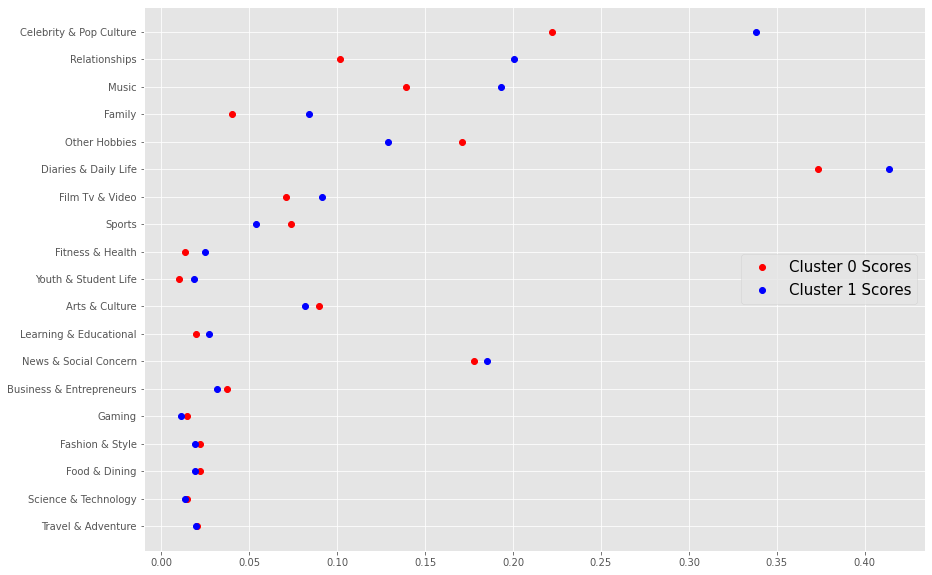

In [36]:
plt.figure(figsize=(14, 10))

y_ticks = two_label_topics_scores.index.str.replace("_", " ").str.title().tolist()
plt.plot(two_label_topics_scores.cluster_0_scores.values, 
         y_ticks, "ro", label = "Cluster 0 Scores")

plt.plot(two_label_topics_scores.cluster_1_scores.values, 
         y_ticks, "bo", label = "Cluster 1 Scores")
plt.legend(loc = 5, fontsize = 15)
plt.show()

#### Emotions

I used the [pysentimiento](https://github.com/pysentimiento/pysentimiento) package to derive the sentiment and emotion scores.


`mean_emotions_sentiment` has the same functionality as mean_topics but for the emotions and sentiments data.

In [38]:
def mean_emotions_sentiment(labels_df):
    label_emotion_means = []
    label_sentiment_means = []
    
    for i in labels_df.columns:
        mean_emotion_cluster = emotions.loc[labels_df[labels_df.loc[:, i]==1].index].mean().rename("cluster_{}_scores".format(i))
        label_emotion_means.append(mean_emotion_cluster)
        
    for i in labels_df.columns:
        mean_sentiment_cluster = sentiment.loc[labels_df[labels_df.loc[:, i]==1].index].mean().rename("cluster_{}_scores".format(i))
        label_sentiment_means.append(mean_sentiment_cluster)
        
    label_emotion_means = pd.concat(label_emotion_means, axis = 1)
    label_emotion_means.index = "Emotion_" + label_emotion_means.index
    label_sentiment_means = pd.concat(label_sentiment_means, axis = 1)
    label_sentiment_means.index = "Sentiment_" + label_sentiment_means.index
    
    label_means = pd.concat([label_emotion_means, label_sentiment_means])
    
    if labels_df.shape[1] > 2:
        label_means["standard_dev"] = label_means.std(axis = 1)
        label_means.sort_values("standard_dev", ascending = True, inplace=True)
    else:
        label_means["absolute_difference"] = label_means.diff(axis = 1).iloc[:, 1].abs()
        label_means.sort_values("absolute_difference", ascending=True, inplace=True)
    
    return label_means
    

In [39]:
two_label_emotion_sentiment = mean_emotions_sentiment(labels2_df)
two_label_emotion_sentiment

,cluster_0_scores,cluster_1_scores,absolute_difference
Emotion_anger,0.006494,0.005583,0.000911
Sentiment_NEG,0.070347,0.069426,0.000921
Emotion_disgust,0.015192,0.013703,0.001488
Emotion_surprise,0.009810,0.005582,0.004228
Emotion_fear,0.006832,0.012406,0.005574
Emotion_sadness,0.112059,0.145978,0.033920
Emotion_joy,0.352377,0.403978,0.051601
Emotion_others,0.497237,0.412769,0.084468
Sentiment_NEU,0.399866,0.230539,0.169327
Sentiment_POS,0.529787,0.700035,0.170248


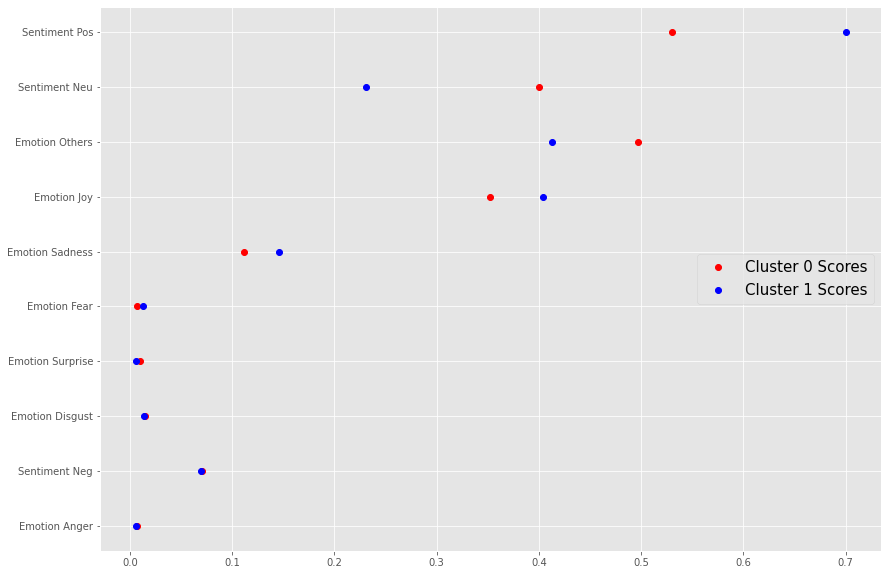

In [40]:
plt.figure(figsize=(14, 10))

y_ticks = two_label_emotion_sentiment.index.str.replace("_", " ").str.title().tolist()
plt.plot(two_label_emotion_sentiment.cluster_0_scores.values, 
         y_ticks, "ro", label = "Cluster 0 Scores")

plt.plot(two_label_emotion_sentiment.cluster_1_scores.values, 
         y_ticks, "bo", label = "Cluster 1 Scores")
plt.legend(loc = 5, fontsize = 15)
plt.show()

### Five Labels


Repeat the topic modeling and emotional/sentiment classification process for the 5-cluster model.

Since there are more than 2 clusters, the outputted table is sorted by standard deviation of a topic's scores instead of absolute difference.

In [41]:
five_label_topics_scores = mean_topics(labels5_df)
five_label_topics_scores.round(3)

,cluster_0_scores,cluster_1_scores,cluster_2_scores,cluster_3_scores,cluster_4_scores,standard_dev
gaming,0.019,0.013,0.008,0.005,0.013,0.005
science_&_technology,0.021,0.012,0.010,0.006,0.012,0.005
fashion_&_style,0.026,0.025,0.017,0.022,0.012,0.006
youth_&_student_life,0.021,0.008,0.017,0.005,0.007,0.007
food_&_dining,0.029,0.016,0.016,0.009,0.018,0.007
fitness_&_health,0.027,0.012,0.022,0.009,0.010,0.008
travel_&_adventure,0.029,0.021,0.016,0.006,0.014,0.009
business_&_entrepreneurs,0.045,0.032,0.023,0.044,0.028,0.010
learning_&_educational,0.033,0.016,0.023,0.007,0.015,0.010
arts_&_culture,0.081,0.094,0.083,0.051,0.103,0.020


Dot plot visualization

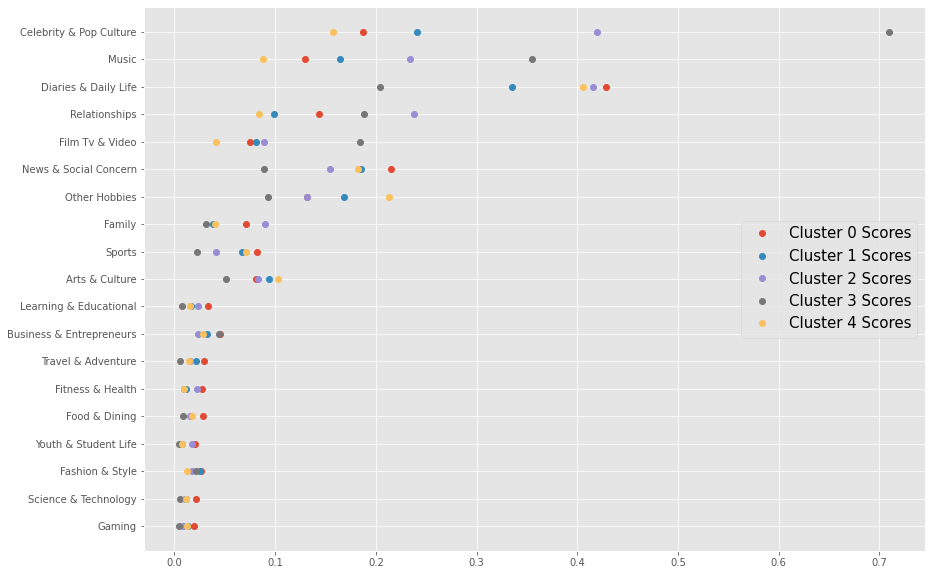

In [42]:
plt.figure(figsize=(14, 10))

y_ticks = five_label_topics_scores.index.str.replace("_", " ").str.title().tolist()

cluster_columns = five_label_topics_scores.columns[:5]

for col in cluster_columns:
    ser = five_label_topics_scores[col].values
    plt.plot(ser, y_ticks, "o", label = col.replace("_", " ").title())

plt.legend(loc = 5, fontsize = 15)
plt.show()

## Centroid Tweets


In order to get a better understanding of a cluster's meaning we look at the nearest neighbors to each cluster's centroid using euclidean distance.

### Two labels

In [43]:
two_label_dists = euclidean_distances(km2.cluster_centers_, prayer_embeddings)
two_label_dists_argsort = two_label_dists.argsort(axis = 1)

In [44]:
def centriod_tweets(dists_argsort, n = 5):    
    output = {}
    
    for i in range(len(dists_argsort)):
        row = dists_argsort[i]
        top_n_args = row[:n]
        tweet_ids = prayer_embeddings.index[top_n_args]
        output["cluster_{}".format(i)] = tweets.loc[tweet_ids].text.tolist()
    return output

Print out the the 15 tweets closest to each centriod

In [50]:
for k, v in centriod_tweets(two_label_dists_argsort, 15).items():
    print(k.title()+":\n")
    for i in v:
        print("|",i, "|")
    print("\n")

Cluster_0:

| @Crypto_Hawkk @MarsEcosystem DONE thanks for the chance 🍀🙏 https://t.co/D8aqNsoyDY |
| @crypto_bearr @Crypto_Moonride DONE thanks for the chance 🍀🙏 https://t.co/rJ2MyzvHrU |
| @DaCryptoMonkey thank you Godless🙏🙏🙏 https://t.co/k3cQ596jTY |
| @Onelovesantana_ @luaanjoCAFETAO oremos! 🙏🙏 |
| @jsmith4966 Keep the faith.❤️🇺🇸🙏 |
| @DonMurillo_ worked thank you! 🙏🙏🙏🙏 |
| @gloriacchao Thank you!!!! 🙏🙏🙏🙏🙏🙏 |
| @doylejacq @BULL_magazine_ Thank you! 🙏🙏 |
| @ArtByT3D Thank you!🙏🙏🙏 |
| I love freelance comp 🙏🙏 https://t.co/guyGbIkAB7 |
| @DebbieDoesTwitt Congratulations 🙏💗🙏 |
| @brainrottings mhm mhm 🙏🙏 |
| Om Ah Hung 🙏🙏🙏 https://t.co/fdVFdrwk0f |
| @QUEENNI16 God ...when?🤔😫🙏🙏 |
| @LlfE_UndErwatEr Thank You for Sharing
            🙏💫🙏🏽 |


Cluster_1:

| @Michael5SOS Hahah, I love you Mikey xx Please come to Japannn🇯🇵❤️🙏 |
| @HeffronDrive I would do anything to get a follow from you. . Please? 🙏 |
| So my son decided to run the Win11 installer on my audio computer. Pray for me! 🙏 https:

In [51]:
five_label_dists = euclidean_distances(km5.cluster_centers_, prayer_embeddings)
five_label_dists_argsort = five_label_dists.argsort(axis = 1)

In [52]:
for k, v in centriod_tweets(five_label_dists_argsort, 15).items():
    print(k.title()+":\n")
    for i in v:
        print("|",i, "|")
    print("\n")

Cluster_0:

| @Trumpster5280 We have to have faith that the Truth will be told at some point🙏 |
| @GuglielminaS Happy New Year! 
Hope you are well and come back soon 🥰🙏 |
| @kathieeliza @OwnTheMomentNFT #13 ! If you don’t mind sending a like my way. Thank you🙏
https://t.co/8CNOOfk01z |
| @selenagomez Been planning on donating to Houston but wasn't sure where to donate. Now I know! 🙏 |
| @FinchMuted @nbatopshot #14 ! If you don’t mind sending a like my way. Thank you🙏
https://t.co/8CNOOfk01z |
| @JusRckless #9 ! If you don’t mind sending a like my way. Thank you🙏
https://t.co/8CNOOfk01z |
| @General_Lew1 We have to fight, and keep up the fight💪🇺🇸🙏 |
| @lareynademejico @bossbabefrvncia First step is acknowledgment. You’re on the right path sis keep going 🤍🙏 |
| @MaryKei91158705 I thank you for that though! Teachers are true heroes in my book!🙏 |
| @killyourfriends I just ordered the sequel Kill Em All I’ll do a review on it on @RoxxxTv thank you John Niven for doing this!🙏 |
| @BeastCauc

**Most distinctive words**


Produces the most representative words from tweets containing a given cluster label.

1. Creates a document term matrix of the entire text for prayer hands emojis.

2. Iterates over clusters labels. 

    a. Grabs ids of tweets contain given cluster label and creates a subset of the dtm
    
    b. Sums up the word frequencies and normalizes them
    
    c. Repeats process for tweets not pertaining to the label.
    
    d. Derives ratio between normalized word frequencies for the in and out of label dtms.
    
    e. Saves ratio to dictionary

In [53]:
prayer_text = prayer_hands_df.reset_index().groupby("tweet_id").text.unique().apply(lambda x:x[0])

In [54]:
countvec = CountVectorizer(max_df=0.5, min_df=0.005,preprocessor=tokenizer.normalizeTweet, stop_words="english")
prayer_dtm = countvec.fit_transform(prayer_text).toarray()
features = countvec.get_feature_names_out()
prayer_dtm = pd.DataFrame(index=prayer_text.index, data = prayer_dtm, columns = features)

In [55]:
def words_ratio(labels_df):
    output = {}
    for i in labels_df.columns:
        label_ids = labels_df[labels_df.loc[:, i] == 1].index
        
        word_counts_label = prayer_dtm.loc[label_ids].sum()
        word_counts_label_norm = word_counts_label/word_counts_label.sum()
        
        word_counts_out_of_label = prayer_dtm.drop(label_ids).sum().replace(0, 1)
        word_counts_out_of_label_norm = word_counts_out_of_label/word_counts_out_of_label.sum()
        ratio = word_counts_label_norm/word_counts_out_of_label_norm
        output["cluster_{}".format(i)] = ratio
    return output

In [56]:
labels2_ratios = words_ratio(labels2_df)

In [57]:
for k, v in labels2_ratios.items():
    
    print("Most distinctive words in {}\n".format(k))
    print(v.nlargest(10), "\n")

Most distinctive words in cluster_0

movie_camera                    7.775935
collision                       6.629307
Done                            3.907663
smiling_face_with_sunglasses    3.745701
rose                            3.237599
Thanks                          3.071935
face_with_tears_of_joy          3.014227
sparkles                        2.793052
bro                             2.782730
clapping_hands                  2.750357
dtype: float64 

Most distinctive words in cluster_1

gift              15.472413
Could              5.841987
YOUR               5.413743
birthday           4.349441
loves              4.064311
strong             3.959200
AaronsNewVideo     3.632653
important          3.603823
Hey                3.363568
followed           3.363568
dtype: float64 



In [58]:
labels5_ratios = words_ratio(labels5_df)

In [59]:
for k, v in labels5_ratios.items():
    
    print("Most distinctive words in {}\n".format(k))
    print(v.nlargest(10), "\n")

Most distinctive words in cluster_0

ll         5.671324
support    5.466892
change     5.375473
work       5.039505
time       4.794623
just       4.627031
look       4.367571
feel       4.124929
gonna      4.114379
believe    4.107597
dtype: float64 

Most distinctive words in cluster_1

movie_camera                    13.458739
rose                             6.906458
clapping_hands                   5.557487
smiling_face_with_sunglasses     3.800115
face_with_tears_of_joy           3.464304
flexed_biceps                    3.252529
dark_skin_tone                   3.049945
thumbs_up                        2.970597
collision                        2.924891
OK_hand                          2.844688
dtype: float64 

Most distinctive words in cluster_2

gift        11.651976
followed     6.305289
strong       4.197437
Could        4.107115
Hey          3.586981
Do           3.332716
proud        3.007151
CAN          2.986845
smile        2.956689
days         2.893076
dtype: float64 

**Visualizing prayer_hands emojis over time**

 Produces three subplots charting the rate of tweet containing cluster labels.
        
- Left plot shows the rate of tweeting for each label.

- Center plot shows a stacked area plot.

- Right plot shows normalized stacked area plt.

In [60]:
prayer_hands_time = prayer_hands_df[["created_at"]]

In [61]:
labels2_df = labels2_df.join(prayer_hands_time)

In [62]:
labels2_df["created_at"] = pd.to_datetime(labels2_df.created_at)

In [63]:
labels2_tweetrate = labels2_df.set_index("created_at").loc[:, [0,1]]
labels2_tweetrate.head()

,0,1
created_at,,
2014-01-30 23:57:31+00:00,1.0,0.0
2014-01-30 23:57:31+00:00,0.0,1.0
2014-01-30 23:57:31+00:00,1.0,0.0
2014-01-30 23:57:31+00:00,0.0,1.0
2014-01-30 23:57:32+00:00,0.0,1.0


(0.0, 1.0)

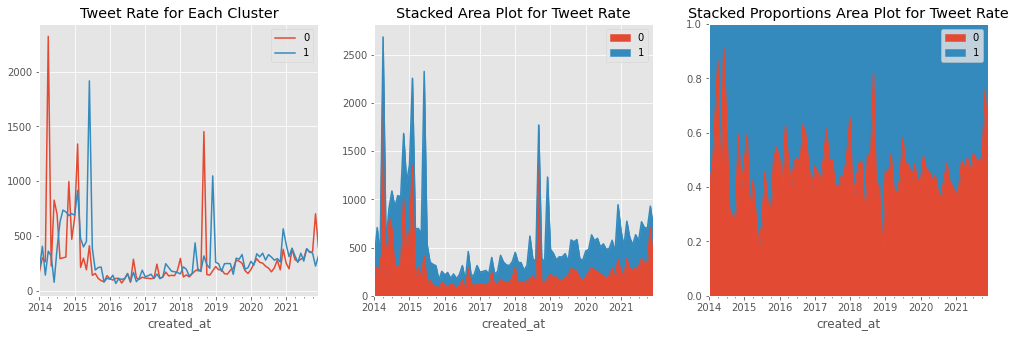

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

monthly_rate = labels2_tweetrate.resample("M").sum()
monthly_rate.plot(ax = axes[0])

axes[0].set_title('Tweet Rate for Each Cluster')

monthly_rate.plot(kind = "area", ax = axes[1])

axes[1].set_title('Stacked Area Plot for Tweet Rate')

monthly_rate.divide(monthly_rate.sum(axis = 1),axis = 0).plot(kind = "area", ax = axes[2])

axes[2].set_title('Stacked Proportions Area Plot for Tweet Rate')
axes[2].set_ylim(0, 1)
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.title("Monthly Tweeting Rate of the Prayer Hands Emoji");

In [65]:
labels5_df = labels5_df.join(prayer_hands_time)

In [66]:
labels5_df["created_at"] = pd.to_datetime(labels5_df.created_at)

In [68]:
labels5_tweetrate = labels5_df.set_index("created_at").loc[:, [0,1,2,3,4]]

In [69]:
labels5_tweetrate.index = pd.to_datetime(labels5_tweetrate.index)

Text(0.5, 1.0, 'Stacked Proportions Area Plot for Tweet Rate')

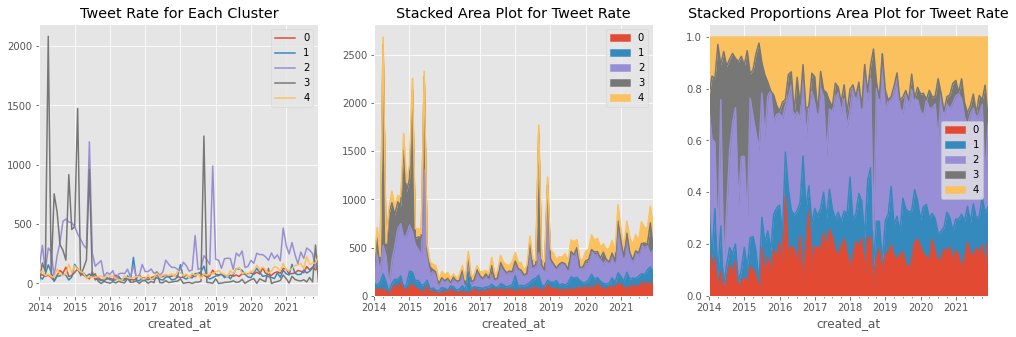

In [70]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(17, 5))

monthly_rate = labels5_tweetrate.resample("M").sum()
monthly_rate.plot(ax = axes[0])

axes[0].set_title('Tweet Rate for Each Cluster')

monthly_rate.plot(kind = "area", ax = axes[1])

axes[1].set_title('Stacked Area Plot for Tweet Rate')

monthly_rate.divide(monthly_rate.sum(axis = 1),axis = 0).plot(kind = "area", ax = axes[2])

axes[2].set_title('Stacked Proportions Area Plot for Tweet Rate')